In [1]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import xgboost as xgb
from sklearn.externals import joblib
%matplotlib inline

In [2]:
aux_columns = ['S5aux0', 'S3aux0', 'S2aux0', 'S0aux0', 'S0aux1', 'S0aux2',
       'S0aux3', 'S2aux1', 'S2aux2', 'S2aux3', 'S0aux4', 'S0aux5',
       'S0aux6', 'S0aux7', 'S0aux8']
out_columns = ['0', '1', '2']
MODEL_NAME = "XGB_apart_old"

In [3]:
vars_list_input = ['S0x0','S0x1','S0x2','S0x3','S0x4','S3x0','S3x1','S2x0','S2x1','S2x2','S2x3','S0x5','S0x6',
 'S0x7','S0x8','S0x9','S0x10','S1x0','S1x1','S1x2','S1x3','S1x4','S1x5','S5x0','S4x0','S4x1','S4x2','S3x2','S4x3',
 'S4x4','S5x1','S5x2','S5x3','S5x4','S4x5']

## XGBoost for PID Classification

In [4]:
pids = ["pion", "electron", "muon", "ghost", "proton", "kaon"]
pid_to_num = {
    name : i for i, name in enumerate(pids)
}

### Train data

In [5]:
# xgb_train_df = pd.read_csv("./data/orig_train_old.csv")
# xgb_train = {}
# for pid in rane(6):
#     train_pid = xgb_train_df[xgb_train_df.pid==pid]
#     xgb_train[pid] = train_pid[vars_list_input].values

### Test data

In [6]:
xgb_test_df = pd.read_csv('./data/orig_test_old.csv')
aux_data = {pid: {} for pid in range(6)}
for pid in range(6):
    test_pid = xgb_test_df[xgb_test_df.pid==pid]
    aux_data[pid]['S0aux7'] = test_pid["S0aux7"].values
    aux_data[pid]['S0aux8'] = test_pid["S0aux8"].values

#### original data

In [7]:
xgb_test_df = pd.read_csv('./data/orig_test_old.csv')
xgb_test = {}
for pid in range(6):
    test_pid = xgb_test_df[xgb_test_df.pid==pid]
    xgb_test[pid] = test_pid[vars_list_input].values

#### data after AE

In [8]:
ae_test_df = pd.read_csv('./data/ae_test_pid_{}_old.csv'.format(3))
ae_test = {}

for pid in range(6):
    test_pid = ae_test_df[ae_test_df.pid==pid]
    ae_test[pid] = test_pid[vars_list_input].values

#### data after AE+GAN

In [9]:
gan_test_df = pd.read_csv('./data/gan_ae_test_dim_{}_old.csv'.format(3))
gan_test = {}
for pid in range(6):
    test_pid = gan_test_df[gan_test_df.pid==pid]
    gan_test[pid] = test_pid[vars_list_input].values

-------------

Train all the xgboost models

In [10]:
# for pid1 in range(6):
#     for pid2 in range(6):
#         if pid1 == pid2:
#             continue
#         X = np.concatenate([xgb_train[pid1], xgb_train[pid2]], axis=0)
#         Y = [0]*len(xgb_train[pid1]) + [1]*len(xgb_train[pid2])

#         clf_name = "XGBoost_old_pids_{}-{}".format(pid1, pid2)
#         clf = xgb.XGBClassifier(nthread=-1, seed=111)
#         clf.fit(X, Y)
#         joblib.dump(clf, os.path.join('xgboost', clf_name) + ".pkl")
# #         clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

### Kaon(f, #5) vs Peon(a, #0)

In [11]:
def get_sorted_ans(clf, data, pid_pos, pid_neg, aux='S0aux7'):
    X = np.concatenate([data[pid_neg], data[pid_pos]], axis=0)
    Y = [0]*len(data[pid_neg]) + [1]*len(xgb_test[pid_pos])
    y_pred = clf.predict_proba(X)[:, 1]
    aux = np.concatenate([aux_data[pid_neg][aux], aux_data[pid_pos][aux]], axis=0)
    sorted_ans = np.array([[x, y, z] for x, (y, z) in zip(y_pred, zip(Y, aux))])
    sorted_ans = np.array(sorted(sorted_ans, key=lambda x: x[2]))
    return sorted_ans[:, 0], sorted_ans[:, 1], sorted_ans[:, 2]

In [12]:
def tpr_fpr(y_true, y_pred):
    tp = np.sum(y_true*y_pred)
    fn = np.sum((1-y_pred)*y_true)
    tn = np.sum((1-y_pred)*(1-y_true))
    fp = np.sum((1-y_true)*y_pred)
    
    return tp/(tp+fn), fp/(fp+tn)

def get_plot_data(pred, true, aux, thres=0.5, true_label=1, bins=20):
    pred = np.array([0 if x < thres else 1 for x in pred])
    true = np.array([1 if x == true_label else 0 for x in true])
    
    
    tprs, fprs = [], []
    
    step = (np.max(aux) - np.min(aux))/bins
    indices = [0]
    aux_index = 0
    for n_step in range(1, bins+1):
        while aux_index < len(aux) and aux[aux_index] < np.min(aux)+step*n_step:
            aux_index += 1
        indices.append(aux_index)
    
    for i in range(1, len(indices)):
        tpr, fpr = tpr_fpr(true[indices[i-1]:indices[i]], pred[indices[i-1]:indices[i]])
        tprs.append(tpr)
        fprs.append(fpr)
        
    return [(aux[min(indices[i], len(aux)-1)] + aux[indices[i-1]])/2 for i in range(1, bins+1)], tprs, fprs

def plot(x, ys, legends, aux='S0aux7', title='', alpha=0.5):
    plt.figure(figsize=(10, 6))
    
    for y, label in zip(ys, legends):
        plt.scatter(x, y, alpha=alpha, label=label)
    
    plt.ylim(-0.2, 1.2)
    plt.xlabel('{} bins'.format(aux))
    plt.ylabel('Efficiency')
    plt.legend(loc="upper left")
    plt.title(title)

In [13]:
def plot_efficiency(data, clf, feature_name, pid_pos, pid_neg, clf_threshold, max_feature_value, title=""):
    pred, true, aux = get_sorted_ans(clf, data, pid_to_num[pid_pos], pid_to_num[pid_neg], aux=feature_name)

    last_index = -1
    for i in range(len(aux)):
        if aux[i] >= max_feature_value:
            last_index = i
            break
    
    x, tpr, fpr = get_plot_data(pred[:last_index], true[:last_index], aux[:last_index], thres=0.5)
    plot(x, [tpr, fpr], 
         legends=["{} identification efficiency, thr={}".format(pid_pos, clf_threshold), 
                  "{} misidentification rate, thr={}".format(pid_neg, clf_threshold)], 
         aux=feature_name, title=title)

    plt.show()
    
def plot_hist(data, pid_pos, pid_neg, feature_name, max_feature_value, bins=20):

    aux = np.concatenate([data[pid_to_num[pid_neg]][feature_name], data[pid_to_num[pid_pos]][feature_name]], axis=0)
    
    indices = []
    for i in range(len(aux)):
        if aux[i] < max_feature_value:
            indices.append(i)
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('{} value'.format(feature_name))
    plt.ylabel('num of {} values per bin'.format(feature_name))
    plt.hist(aux[indices], bins=bins, histtype='step')
    plt.title('{} values histogram'.format(feature_name))
    plt.show()

In [14]:
pid_neg = 'pion'
pid_pos = 'proton'
feature_name = 'S0aux7'
clf_threshold = 0.5
max_feature_value = 46885  

In [15]:
# Parameters
pid_pos = "electron"
pid_neg = "ghost"


In [16]:
import holoviews as hv
from holoviews.operation import contours
hv.extension()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

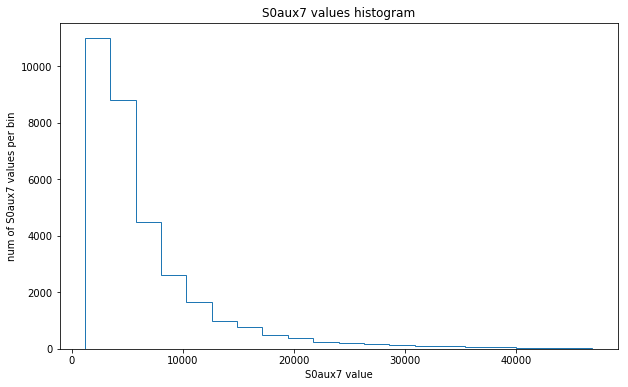

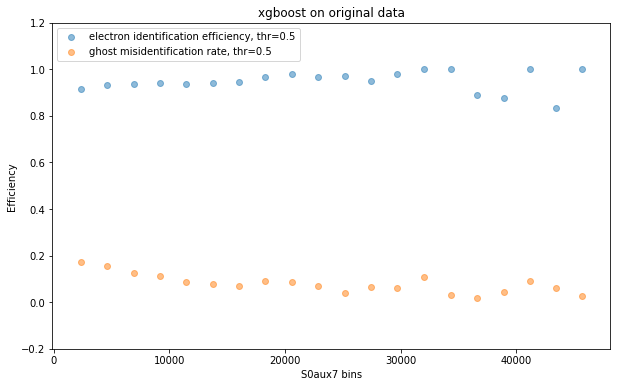

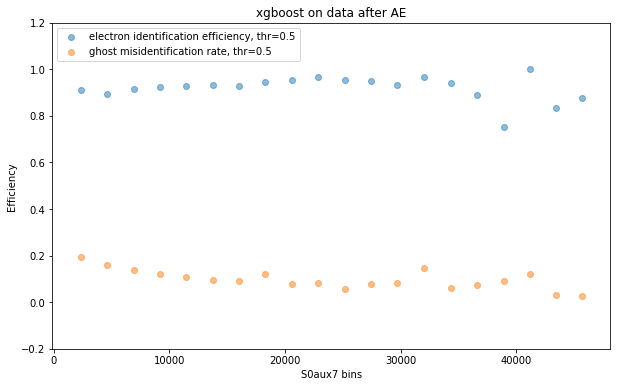

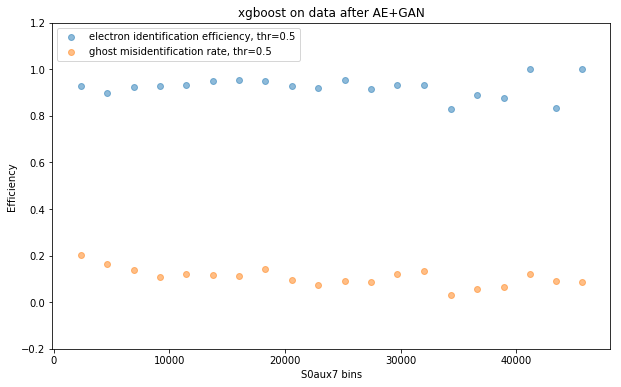

In [17]:
%%output filename="/mnt/tgaintseva/compression/penguin_plot" fig="png"

clf_name = "XGBoost_old_pids_{}-{}".format(pid_to_num[pid_neg], pid_to_num[pid_pos])
clf = xgb.XGBClassifier(nthread=-1, seed=111)
clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

plot_hist(aux_data, pid_pos, pid_neg, feature_name, max_feature_value)

datas = {
    "xgboost on original data": xgb_test,
    "xgboost on data after AE": ae_test,
    "xgboost on data after AE+GAN": gan_test
}

for data_descr in datas:
    plot_efficiency(datas[data_descr], clf, feature_name, pid_pos, pid_neg, 
                    clf_threshold, max_feature_value, title=data_descr)